**sep使用向导**  
_2021.11.04_

In [1]:
import sep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib import rcParams
rcParams['figure.figsize'] = [10., 8.]

# 加载图片并显示

In [12]:
hdul = fits.open('image.fits')
hdul.info()
data = hdul[0].data

Filename: image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     337   (256, 256)   int16 (rescales to float32)   


In [7]:
m, s = np.mean(data), np.std(data) # * 计算数据的标准差
print(m, s)

6887.266 966.7967


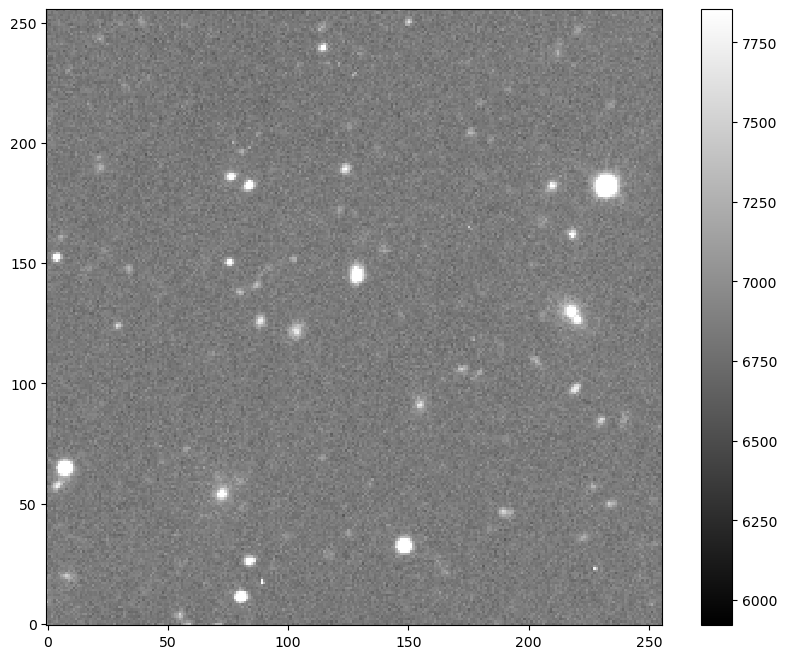

In [8]:
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()

# Background subtraction (扣除背景)  
**！不进行背景扣除，或者object detection的threshold设置过低都会使得检测到的源的数量增加**

## 生成Background对象  
sep会自动根据图像生成背景对象

In [9]:
bkg = sep.Background(data) # ^ 参数说明见说明

## 查看图像背景的全局平均值和噪声

In [10]:
print(bkg.globalback)
print(bkg.globalrms)

6852.04931640625
65.46174621582031


## 将背景转成2维数组  
用于生成图片

In [13]:
bkg_image = np.array(bkg)

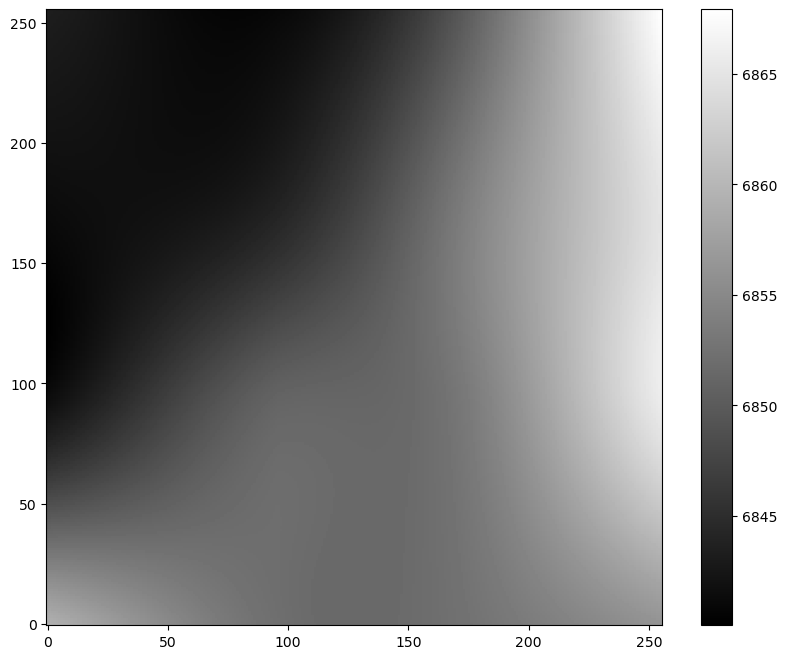

In [15]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

## 生成背景噪声

In [16]:
bkg_rms = bkg.rms() # ^ 返回2维数组

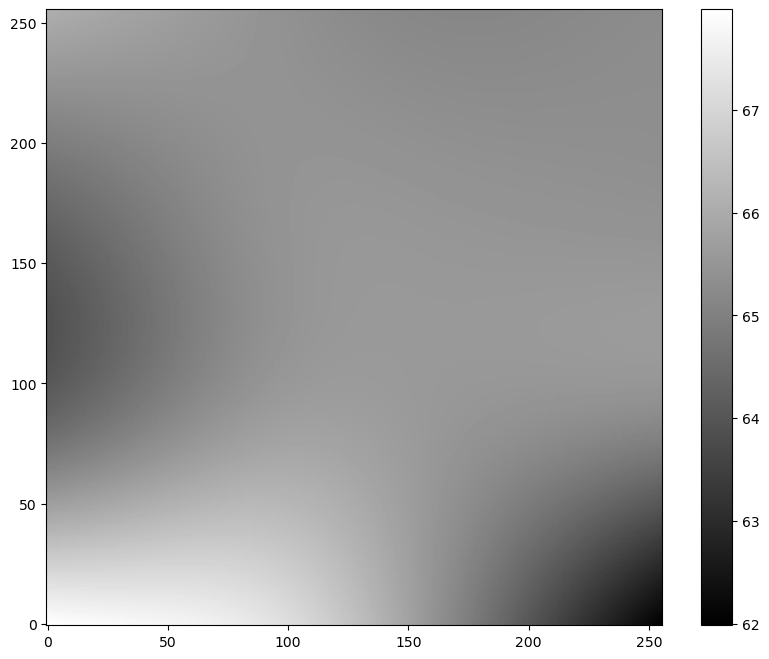

In [17]:
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

## 扣除背景 (subtract the background)  
生成扣除背景后的图片

In [18]:
data_sub = data - bkg

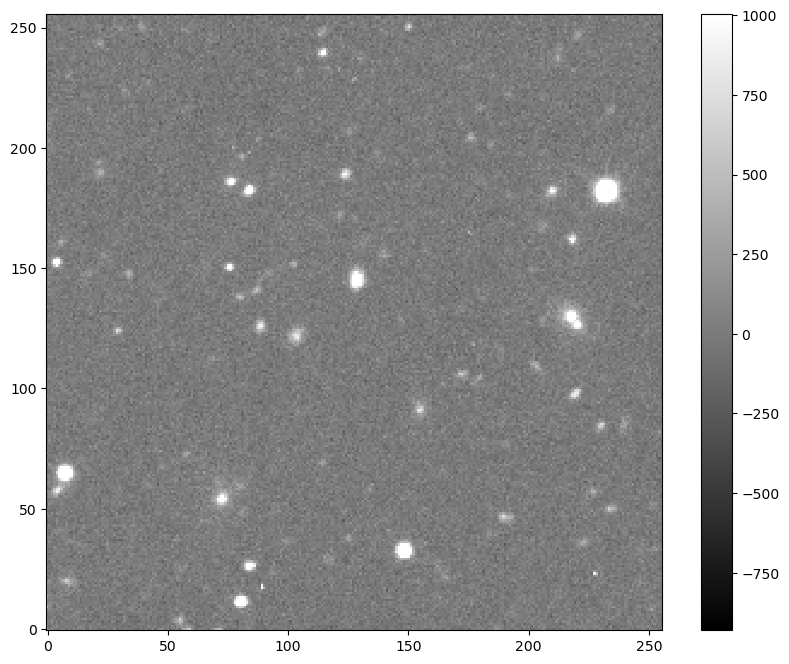

In [19]:
m, s = np.mean(data_sub), np.std(data_sub)
plt.imshow(data_sub, interpolation='nearest', cmap='gray',  vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

# Object detection (目标检测)

## `sep.extract()`在图片中找源  
返回一个1维数组，每个元素是一个元组，每个元组存储一个源的信息  

参数说明：  
* data_sub: 减去图片背景后的image
* 后两个参数是探测阈值：1.5*err, 其中err是全局背景均方根(global background RMS)

In [20]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

In [21]:
objects.shape # * 找到了68个源

(68,)

In [22]:
para = pd.DataFrame({
    'name': objects.dtype.names, 
    'o0':list(objects[0]), 
    'o1':list(objects[1]), 
    'o2':list(objects[2])
    })
para

,name,o0,o1,o2
0,thresh,98.192619,98.192619,98.192619
1,npix,9.000000,9.000000,23.000000
2,tnpix,6.000000,9.000000,19.000000
3,xmin,69.000000,56.000000,53.000000
4,xmax,73.000000,60.000000,57.000000
5,ymin,0.000000,0.000000,1.000000
6,ymax,1.000000,1.000000,6.000000
7,x,71.178888,58.221053,55.161820
8,y,0.379799,0.364984,3.510851
9,x2,1.369634,1.318046,1.268402


## 输出已识别源的面心坐标

In [23]:
objects['x']

array([ 71.17888761,  58.22105287,  55.16181962,   0.45401343,
        80.42503984,  89.04747569,   8.64447998, 227.47174009,
       165.04661019,  84.01635678, 116.8178964 ,  99.03989844,
       148.19980293, 222.38918555, 125.12400581, 190.2008698 ,
       233.82210488, 226.4325878 ,  79.77309809,  72.42688967,
         4.45282038,   7.42863626, 114.06675775,  57.79367481,
       229.76541053, 239.50868812, 154.65669215, 219.07693614,
       178.64091162, 172.07230503, 203.1013384 ,  29.39086525,
       103.44117928,  88.45070221, 217.56779245,  80.07791303,
        16.92529964,  33.79709102,  86.92946333, 128.54519216,
        75.60098192, 102.291015  ,   4.02261641, 139.80532064,
         5.82095114, 217.91293143, 175.19837233, 205.55802127,
       121.43571269, 209.52233796,  83.81749241,  76.2926371 ,
       123.8711646 , 232.029973  ,  22.00108095,  80.59425855,
       175.83277824, 125.31930321,   0.4244312 , 233.66729976,
        32.54575371, 114.39597212, 211.97442641,  21.71

In [24]:
objects['y']

array([  0.37979937,   0.36498433,   3.51085085,   9.07260376,
        11.30104137,  17.1970524 ,  19.65108369,  23.00906247,
        21.64313034,  26.29189255,  28.76297128,  36.32406468,
        32.51661813,  35.81366964,  37.81966747,  46.31159838,
        49.84700216,  56.92540121,  59.35856335,  54.56497054,
        57.7961616 ,  64.69412009,  69.00566125,  72.54298779,
        84.34773602,  85.11737268,  91.22631781,  97.60183758,
       103.8784743 , 105.64978714, 109.06059754, 123.90549853,
       121.86100634, 125.80909887, 129.03227709, 138.00275486,
       147.72546408, 147.41375215, 141.2882075 , 145.28574865,
       150.18644119, 151.58203822, 152.3512722 , 155.75523455,
       160.48742153, 161.97496874, 164.85386526, 167.14889542,
       171.89106504, 181.86068413, 182.27089834, 185.95318277,
       188.99211129, 182.02661958, 189.52441198, 196.24972816,
       204.26456143, 206.92436468, 209.19444944, 215.64051901,
       223.52663443, 239.49256969, 238.41593116, 243.35

## 已识别源的检测信息  

|参数|解释|单位|
|---|---|---|
|thresh (float) |Threshold at object location.|
|npix (int) |Number of pixels belonging to the object.|
|tnpix (int) |Number of pixels above threshold (unconvolved data)|
|xmin, xmax (int) |Minimum, maximum x coordinates of pixels.|
|ymin, ymax (int) |Minimum, maximum y coordinates of pixels.|
|x, y (float) |object barycenter (first moments).|
|x2, y2, xy (float) |Second moments.|
|errx2, erry2, errxy (float) |Second moment errors. Note that these will be zero if error is not given.|
|a, b, theta (float) |Ellipse parameters|pixel(a, b); deg(theta)|
|cxx, cyy, cxy (float) |Alternative ellipse parameters.|
|cflux (float) |Sum of member pixels in convolved data.|
|flux (float) |Sum of member pixels in unconvolved data.|
|cpeak (float) |Peak value in convolved data.|
|peak (float) |Peak value in unconvolved data.|
|xcpeak, ycpeak (int) |Coordinate of convolved peak pixel.|
|xpeak, ypeak (int) |Coordinate of unconvolved peak pixel.|
|flag (int) |Extraction flags.|

In [25]:
objects.dtype.names # * 输出可以查看的信息名称

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

In [26]:
objects['xpeak']

array([ 72,  59,  55,   0,  80,  89,   8, 227, 166,  84, 115,  98, 148,
       223, 125, 189, 233, 227,  80,  73,   4,   7, 114,  59, 230, 240,
       155, 219, 180, 172, 203,  29, 104,  88, 218,  80,  17,  34,  87,
       129,  76, 102,   4, 140,   6, 218, 175, 207, 121, 210,  84,  76,
       124, 232,  22,  81, 175, 126,   0, 234,  32, 114, 212,  22, 221,
       113,  39, 150])

## 画图展示：用椭圆圈出已识别源

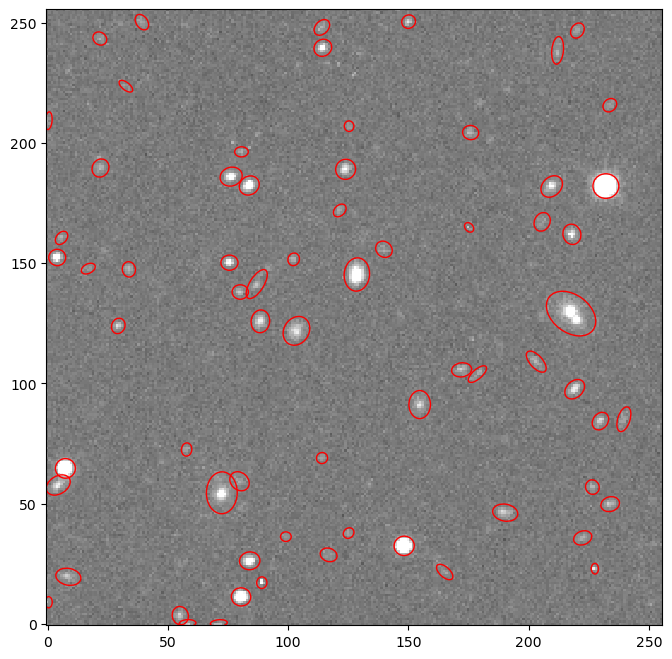

In [27]:
from matplotlib.patches import Ellipse
fig, ax = plt.subplots()

# * 画出扣除背景后的image
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

# * 用椭圆圈出识别到的源
for i in range(len(objects)):
    e = Ellipse(
        xy = (objects['x'][i], objects['y'][i]), 
        width = 6 * objects['a'][i],
        height = 6 * objects['b'][i],
        angle = objects['theta'][i] * 180. / np.pi
    )
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

# Aperture photometry (孔径测光)  
按aperture是圆/椭圆、是否是环，SEP提供了4个孔径测光的函数  

|Function|Sums data within|
|---|---|
|`sep.sum_circle`|circle|
|`sep.sum_circann`|circular annulus|
|`sep.sum_ellipse`|ellipse|
|`sep.sum_ellipann`|elliptical annulus|

对检测到的objects进行孔径测光（孔径：3 pixel radius）

## `sep.sum_circle()`测flux

In [20]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=bkg.globalrms, gain=1.0)

In [21]:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 2249.159297 +/- 291.027802
object 1: flux = 3092.220430 +/- 291.592204
object 2: flux = 5949.868379 +/- 356.562003
object 3: flux = 1851.426582 +/- 295.028816
object 4: flux = 72736.386914 +/- 440.172206
object 5: flux = 3860.756152 +/- 352.163162
object 6: flux = 6418.913789 +/- 357.458973
object 7: flux = 2210.707656 +/- 350.791223
object 8: flux = 2741.607227 +/- 352.277746
object 9: flux = 20916.875566 +/- 376.966138


## `sep.kron_radius()`测Kron radius

In [22]:
kronrad, krflag = sep.kron_radius(
    data_sub, 
    objects['x'], 
    objects['y'], 
    objects['a'], 
    objects['b'], 
    objects['theta'], 
    6
    )

In [23]:
for i in range(10):
    print("object {:d}: Kron radius = {:f}".format(i, kronrad[i]))

object 0: Kron radius = 1.251966
object 1: Kron radius = 2.501612
object 2: Kron radius = 1.833701
object 3: Kron radius = 2.506136
object 4: Kron radius = 1.179764
object 5: Kron radius = 0.491341
object 6: Kron radius = 2.251447
object 7: Kron radius = 2.264332
object 8: Kron radius = 2.479840
object 9: Kron radius = 0.702324


# Source Extractor的SEP实现

## FLUX_AUTO（e.g. MAG_AUTO）  
第一步：计算目标的Kron radius  
第二步：使用椭圆测光

In [58]:
kronrad, krflag = sep.kron_radius(
    data_sub, 
    objects['x'], 
    objects['y'], 
    objects['a'], 
    objects['b'], 
    objects['theta'], 
    6.0
)

flux, fluxerr, flag = sep.sum_ellipse(
    data_sub, 
    objects['x'], 
    objects['y'], 
    objects['a'], 
    objects['b'], 
    objects['theta'],  
    2.5*kronrad, 
    subpix=1   
)
flag |= krflag
# * 上面的参数设置对应SExtractor中PHOT_AUTOPARAMS 2.5, 0.0

# ^ 如果Kron radius过小，应使用圆孔径测光
r_min = 1.75  # * 设置一个阈值（对应最小直径3.5）
use_circle = kronrad * np.sqrt(objects['a'] * objects['b']) < r_min  # * 椭圆的等效半径小于阈值将使用圆孔径测光，返回bool值
cflux, cfluxerr, cflag = sep.sum_circle(
    data_sub, 
    objects['x'][use_circle], 
    objects['y'][use_circle], 
    r_min, 
    subpix=1
    )

flux[use_circle] = cflux
fluxerr[use_circle] = cfluxerr
flag[use_circle] = cflag

In [59]:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 1675.082520 +/- 0.000000
object 1: flux = 4477.378906 +/- 0.000000
object 2: flux = 8298.139160 +/- 0.000000
object 3: flux = 1389.749023 +/- 0.000000
object 4: flux = 57944.316895 +/- 0.000000
object 5: flux = 3584.703613 +/- 0.000000
object 6: flux = 11633.615234 +/- 0.000000
object 7: flux = 1765.896973 +/- 0.000000
object 8: flux = 4767.045898 +/- 0.000000
object 9: flux = 14197.805664 +/- 0.000000


## FLUX_RADIUS  
* 在SEXtractor中，FLUX_RADIUS给出`total flux`的某一分数对应的半径。例如：如果设置`PHOT_FLUXFRAC 0.5`，则给出目标源的`半光半径`。
* 对于`total flux`，SExtractor用上面的FLUX_AUTO给出

In [64]:
#
# ^ 计算半光半径，用到上面计算的flux
r, flag = sep.flux_radius(
    data_sub, 
    objects['x'], 
    objects['y'], 
    6.*objects['a'], 
    0.5, 
    normflux=flux, 
    subpix=5
)
r

array([16, 16, 16, 16,  0,  0, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, 16, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, 16,  0, 16,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, 16,  0,  0,  0,  0,  0,  0, 16, 16, 16],
      dtype=int16)

In [65]:
#
# ^ multiple flux fractions
r, flag = sep.flux_radius(
    data_sub, 
    objects['x'], 
    objects['y'], 
    6.*objects['a'], 
    [0.5, 1], 
    normflux=flux, 
    subpix=5
)
r

array([[ 0.94232461,  1.64341456],
       [ 1.7997767 ,  4.20296428],
       [ 2.00809452,  7.6447885 ],
       [ 0.86351785,  1.59176172],
       [ 0.99983144,  1.88633137],
       [ 0.58189268,  1.60734341],
       [ 2.71141589,  8.67275269],
       [ 0.6978155 ,  1.45866731],
       [ 2.4717599 ,  8.35898995],
       [ 1.09860304,  1.80147037],
       [ 1.18943724,  1.69735678],
       [ 1.71040503,  4.42820864],
       [ 1.005548  ,  1.81457717],
       [ 1.83378136,  5.66158874],
       [ 1.05661673,  1.69457655],
       [ 1.99083781,  6.18764731],
       [ 1.10350544,  1.72335376],
       [ 1.00252303,  1.72796565],
       [ 8.35051856,  8.77832437],
       [ 4.67919706, 14.70655744],
       [ 7.5590706 , 10.73652005],
       [ 1.00147231,  1.94574859],
       [ 1.04665601,  1.74645015],
       [ 1.06151371,  1.89738762],
       [ 1.07833527,  1.7660606 ],
       [ 2.08822832,  4.29262116],
       [ 2.70324561,  9.12030622],
       [ 1.14691476,  1.80034154],
       [ 1.5821633 ,

## XWIN_IMAGE & YWIN_IMAGE  
* XWIN_IMAGE, YWIN_IMAGE比X_IMAGE, Y_IMAGE更精确，在SExtractor中用winpos函数来提取。  
* sig参数：sig = 2. / 2.35 * (half-light radius)，用来描述effevtive width  

In [71]:
#
# ^ 生成半光半径
r, flag = sep.flux_radius(
    data_sub, 
    objects['x'], 
    objects['y'], 
    6.*objects['a'], 
    0.5, 
    normflux=flux, 
    subpix=5
)

sig = 2. / 2.35 * r 
xwin, ywin, flag = sep.winpos(data_sub, objects['x'], objects['y'], sig)
xwin

array([7.13132554e+01, 5.50816490e+01, 5.51197421e+01, 1.68868040e-01,
       8.04266475e+01, 8.90259112e+01, 8.55229573e+00, 2.27211110e+02,
       1.64633990e+02, 8.39992594e+01, 1.17226576e+02, 9.92592671e+01,
       1.48202600e+02, 2.22508929e+02, 1.25105253e+02, 1.89888779e+02,
       2.33515150e+02, 2.26410025e+02, 7.27388937e+01, 7.25831054e+01,
       7.15566516e+00, 7.43113489e+00, 1.14182114e+02, 5.77748490e+01,
       2.29892109e+02, 2.39572011e+02, 1.54718204e+02, 2.19159529e+02,
       1.79143443e+02, 1.72106933e+02, 2.02818367e+02, 2.93669724e+01,
       1.03381829e+02, 8.84413541e+01, 2.17971105e+02, 8.00957892e+01,
       1.64456243e+01, 3.39050079e+01, 8.38201368e+01, 1.28548720e+02,
       7.56657418e+01, 1.02253477e+02, 4.09053824e+00, 1.39686321e+02,
       5.67411425e+00, 2.17942938e+02, 1.75025143e+02, 2.05539537e+02,
       1.21373224e+02, 2.09531196e+02, 8.39143942e+01, 8.15216405e+01,
       1.23803119e+02, 2.32035915e+02, 2.18883501e+01, 8.07257577e+01,
      